## Import

In [1]:
# import sys
# sys.path.append(r'C:\Users\hyeJunoh\Desktop\인턴폴더\연구')

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

import torchvision
import torchvision.transforms as transforms
from torchvision import models, datasets

from sklearn.metrics import f1_score, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE

import os
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
import random
import h5py
import glob
from pathlib import Path
import argparse
import time


import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore')

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


c:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
c:\Users\SHRM_DL\.conda\envs\jun\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"
<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from dataset.loader import dataloader
from train_test.train_teacher import teacher_train
from train_test.test_teacher import testing_teacher
from model.teacher_model import teacher_encoder,  teacher_classifier
from model.attention import SpatialAttention, CrossAttention
from model.cnn import BasicBlock,GlobalAvgPool1D
from model.student_model import student_encoder,student_classifier,Domain_classifier
from train_test.train_student import student_train
from train_test.valid_student import student_valid
from utils.util import multi_acc

In [3]:
CFG = {
    'EPOCHS': 80,
    'LEARNING_RATE':1e-2,
    'BATCH_SIZE':256,
    'SEED':41
}

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(CFG['SEED'])

## Data Load

In [4]:
source1_train_dataloader,source1_valid_dataloader,source1_test_dataloader,source2_train_dataloader,source2_valid_dataloader,source2_test_dataloader,target_train_dataloader,target_valid_dataloader,target_test_dataloaders=dataloader()

# Teacher model

In [5]:
def teacher_enc(pretrained=False, **kwargs):
    model = teacher_encoder(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model## Run (Teacher Model)
def teacher_clas(pretrained=False, **kwargs):
    model = teacher_classifier(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model## Run (Teacher Model)
best_teacher_encoder = teacher_enc().to(device)
best_teacher_classifier = teacher_clas().to(device)
best_spectral_attention_cur = SpatialAttention(in_channels=32, reduction_ratio=16, version='cur').to(device)
best_spectral_attention_vib = SpatialAttention(in_channels=32, reduction_ratio=16, version='vib').to(device)
best_multiview_CrossAttention = CrossAttention(input_size=4096, version='default').to(device)
best_temporal_attention_cur = SpatialAttention(in_channels=32, reduction_ratio=16, version='cur_2').to(device)
best_temporal_attention_vib = SpatialAttention(in_channels=32, reduction_ratio=16, version='vib_2').to(device)


best_teacher_encoder.load_state_dict(torch.load("../../weights/best_teacher_encoder.pth",map_location=device))
best_temporal_attention_cur.load_state_dict(torch.load("../../weights/best_temporal_attention_cur.pth",map_location=device))
best_temporal_attention_vib.load_state_dict(torch.load("../../weights/best_temporal_attention_vib.pth",map_location=device))
best_spectral_attention_cur.load_state_dict(torch.load("../../weights/best_spectral_attention_cur.pth",map_location=device))
best_spectral_attention_vib.load_state_dict(torch.load("../../weights/best_spectral_attention_vib.pth",map_location=device))
best_multiview_CrossAttention.load_state_dict(torch.load("../../weights/best_multiview_CrossAttention.pth",map_location=device))
best_teacher_classifier.load_state_dict(torch.load("../../weights/best_teacher_classifier.pth",map_location=device))


<All keys matched successfully>

# Student model

In [6]:
def student_enc(pretrained=False, **kwargs):
    model = student_encoder(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model## Run (Teacher Model)
def student_clas(pretrained=False, **kwargs):
    model = student_classifier(BasicBlock, [2, 2, 2, 2], **kwargs)
    return model

student_encoder = student_enc().to(device)
student_classifier = student_clas().to(device)

student_discriminator1=Domain_classifier().to(device)
student_discriminator2=Domain_classifier().to(device)

In [7]:

st_optimizer = torch.optim.Adam([
                        {'params': student_encoder.parameters()},
                        {'params': student_classifier.parameters()},
                        {'params': student_discriminator1.parameters()},
                        {'params': student_discriminator2.parameters()},
                        ], lr= 0.0001)

st_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(st_optimizer, mode='max', factor=0.5, patience=15, threshold_mode='abs',min_lr=1e-8, verbose=True)

In [8]:
min_val_score=99999999999
loss1_list,acc1_list=[],[]
loss2_list,acc2_list=[],[]
loss3_list,acc3_list=[],[]
weights1=[]
weights2=[]
cmdvals=[]

for epoch in range(200):
    print("------------------------------")
    print('Epoch: {}'.format(epoch))
    print("-----------Train--------------")
    best_student_encoder,best_student_classifier,best_student_discriminator1,best_student_discriminator2,cmdval,weight1,weight2=student_train(best_teacher_encoder,best_temporal_attention_cur,best_temporal_attention_vib,best_spectral_attention_cur,best_spectral_attention_vib,best_multiview_CrossAttention,best_teacher_classifier,student_encoder,student_classifier, student_discriminator1,student_discriminator2, st_optimizer, source1_train_dataloader,source2_train_dataloader,target_train_dataloader,epoch)
    print("-----------valid--------------")
    loss1, acc1=student_valid(best_student_encoder, best_student_classifier, source1_valid_dataloader)
    loss2, acc2=student_valid(best_student_encoder, best_student_classifier, source2_valid_dataloader)
    loss3, acc3=student_valid(best_student_encoder, best_student_classifier, target_valid_dataloader)
    print("source1 loss:",loss1,"source1 accuracy: ",acc1)
    print("source2 loss:",loss2,"source2 accuracy: ",acc2)
    print("target loss:",loss3,"target accuracy: ",acc3)
    print("cmd value: ",cmdval,"weight1: ",weight1,"weight2: ",weight2)
    loss1_list.append(loss1)
    loss2_list.append(loss2)
    loss3_list.append(loss3)
    acc1_list.append(acc1)
    acc2_list.append(acc2)
    acc3_list.append(acc3)
    weights1.append(weight1)
    weights2.append(weight2)
    cmdvals.append(cmdval)
    
    
    if cmdval < min_val_score:
        torch.save(best_student_encoder.state_dict(),open("../../weights/best_student_encoder.pth","wb"))
        torch.save(best_student_classifier.state_dict(),open("../../weights/best_student_classifier.pth","wb"))
        torch.save(best_student_discriminator1.state_dict(),open("../../weights/best_student_discriminator1.pth","wb"))
        torch.save(best_student_discriminator2.state_dict(),open("../../weights/best_student_discriminator2.pth","wb"))
        max_val_score = cmdval
        

------------------------------
Epoch: 0
-----------Train--------------
class loss:  tensor(0.5708, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0704, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.7682, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.7641, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.1735, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 176.58it/s]


source1 loss: 0.58 source1 accuracy:  90.74605451936873
source2 loss: 0.542 source2 accuracy:  98.92395982783357
target loss: 1.017 target accuracy:  78.04878048780488
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 1
-----------Train--------------
class loss:  tensor(0.5311, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0699, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8433, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8729, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.3172, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 176.10it/s]


source1 loss: 0.501 source1 accuracy:  96.05451936872309
source2 loss: 0.455 source2 accuracy:  100.0
target loss: 0.981 target accuracy:  77.18794835007174
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 2
-----------Train--------------
class loss:  tensor(0.4693, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0691, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8917, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.9011, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.3312, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 176.22it/s]


source1 loss: 0.471 source1 accuracy:  99.78479196556671
source2 loss: 0.55 source2 accuracy:  98.92395982783357
target loss: 0.983 target accuracy:  79.62697274031564
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 3
-----------Train--------------
class loss:  tensor(0.4996, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0683, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8995, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.9155, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.3829, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 174.86it/s]


source1 loss: 0.443 source1 accuracy:  100.0
source2 loss: 0.497 source2 accuracy:  99.78479196556671
target loss: 0.999 target accuracy:  78.1922525107604
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 4
-----------Train--------------
class loss:  tensor(0.4752, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0675, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8825, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8937, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.3189, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 176.60it/s]


source1 loss: 0.434 source1 accuracy:  100.0
source2 loss: 0.506 source2 accuracy:  92.53945480631278
target loss: 1.158 target accuracy:  63.27116212338594
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 5
-----------Train--------------
class loss:  tensor(0.4527, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0682, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.9010, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8764, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2982, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 177.86it/s]


source1 loss: 0.449 source1 accuracy:  100.0
source2 loss: 0.46 source2 accuracy:  99.92826398852223
target loss: 1.103 target accuracy:  66.71449067431851
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 6
-----------Train--------------
class loss:  tensor(0.4643, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0672, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8802, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.9035, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.3152, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 177.32it/s]


source1 loss: 0.338 source1 accuracy:  100.0
source2 loss: 0.425 source2 accuracy:  99.78479196556671
target loss: 1.006 target accuracy:  77.61836441893831
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 7
-----------Train--------------
class loss:  tensor(0.4573, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0671, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8755, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8903, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2901, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 178.12it/s]


source1 loss: 0.355 source1 accuracy:  100.0
source2 loss: 0.42 source2 accuracy:  100.0
target loss: 1.019 target accuracy:  77.61836441893831
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 8
-----------Train--------------
class loss:  tensor(0.4391, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0658, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8800, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8847, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2697, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 179.37it/s]


source1 loss: 0.358 source1 accuracy:  100.0
source2 loss: 0.55 source2 accuracy:  89.52654232424678
target loss: 1.106 target accuracy:  67.43185078909613
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 9
-----------Train--------------
class loss:  tensor(0.4104, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0647, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8511, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8796, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2058, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:03<00:00, 178.60it/s]


source1 loss: 0.342 source1 accuracy:  100.0
source2 loss: 0.419 source2 accuracy:  99.35437589670015
target loss: 1.07 target accuracy:  71.87948350071736
cmd value:  999999999999 weight1:  0.5 weight2:  0.5
------------------------------
Epoch: 10
-----------Train--------------
class loss:  tensor(0.4233, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0640, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8412, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8788, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2073, device='cuda:0', grad_fn=<AddBackward0>)
-----------valid--------------


100%|██████████| 697/697 [00:04<00:00, 173.35it/s]


source1 loss: 0.34 source1 accuracy:  100.0
source2 loss: 0.531 source2 accuracy:  96.48493543758967
target loss: 0.911 target accuracy:  65.85365853658537
cmd value:  tensor(4834.9561, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.5620, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.4380, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 11
-----------Train--------------
cmd1:  tensor(3080.2510, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(5439.6167, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.6385, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3615, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.3966, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0635, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8342, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8578, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.1521, device

100%|██████████| 697/697 [00:04<00:00, 167.60it/s]


source1 loss: 0.315 source1 accuracy:  100.0
source2 loss: 0.521 source2 accuracy:  97.48923959827833
target loss: 0.848 target accuracy:  86.51362984218078
cmd value:  tensor(4118.1138, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.6385, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.3615, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 12
-----------Train--------------
cmd1:  tensor(2651.9771, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(4074.3220, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.6057, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.3943, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.4430, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0639, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8558, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8728, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.2355, devic

100%|██████████| 697/697 [00:04<00:00, 167.43it/s]


source1 loss: 0.347 source1 accuracy:  99.78479196556671
source2 loss: 0.45 source2 accuracy:  100.0
target loss: 1.038 target accuracy:  72.02295552367288
cmd value:  tensor(4160.1040, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.6057, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.3943, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 13
-----------Train--------------
cmd1:  tensor(2152.3643, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(3195.9084, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.5976, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4024, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.3800, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0625, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8560, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8439, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.1424, device

100%|██████████| 697/697 [00:04<00:00, 168.27it/s]


source1 loss: 0.335 source1 accuracy:  100.0
source2 loss: 0.563 source2 accuracy:  96.34146341463415
target loss: 1.016 target accuracy:  65.13629842180775
cmd value:  tensor(4310.5156, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.5976, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.4024, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 14
-----------Train--------------
cmd1:  tensor(2803.8406, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(2915.7483, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.5098, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4902, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.3906, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0632, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8518, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8278, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2.1334, devic

100%|██████████| 697/697 [00:04<00:00, 172.31it/s]


source1 loss: 0.368 source1 accuracy:  99.78479196556671
source2 loss: 0.399 source2 accuracy:  97.77618364418939
target loss: 0.908 target accuracy:  80.48780487804878
cmd value:  tensor(3685.6040, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.5098, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.4902, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 15
-----------Train--------------
cmd1:  tensor(3479.1736, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(4813.6577, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.5805, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.4195, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.3802, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0621, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.8325, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.8001, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(2

100%|██████████| 697/697 [00:04<00:00, 169.02it/s]


source1 loss: 0.27 source1 accuracy:  100.0
source2 loss: 0.527 source2 accuracy:  93.974175035868
target loss: 0.832 target accuracy:  87.66140602582496
cmd value:  tensor(3852.5454, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.5805, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.4195, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 16
-----------Train--------------
cmd1:  tensor(2821.7112, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(2354.4365, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.4549, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.5451, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.3908, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0612, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.7552, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.7803, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(1.9875, device='

100%|██████████| 697/697 [00:04<00:00, 157.26it/s]


source1 loss: 0.388 source1 accuracy:  100.0
source2 loss: 0.478 source2 accuracy:  100.0
target loss: 0.903 target accuracy:  88.95265423242468
cmd value:  tensor(3847.2397, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.4549, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.5451, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 17
-----------Train--------------
cmd1:  tensor(5542.4331, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(5349.5825, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.4911, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.5089, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.4140, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0604, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.7634, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.7438, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(1.9816, device='cuda:0', 

100%|██████████| 697/697 [00:04<00:00, 157.61it/s]


source1 loss: 0.269 source1 accuracy:  100.0
source2 loss: 0.518 source2 accuracy:  98.92395982783357
target loss: 0.919 target accuracy:  87.8048780487805
cmd value:  tensor(3381.1802, device='cuda:0', grad_fn=<AddBackward0>) weight1:  tensor(0.4911, device='cuda:0', grad_fn=<DivBackward0>) weight2:  tensor(0.5089, device='cuda:0', grad_fn=<DivBackward0>)
------------------------------
Epoch: 18
-----------Train--------------
cmd1:  tensor(13073.9199, device='cuda:0', grad_fn=<AddBackward0>)
cmd2:  tensor(1763.2544, device='cuda:0', grad_fn=<AddBackward0>)
weight1 and 2:  tensor(0.1188, device='cuda:0', grad_fn=<DivBackward0>) tensor(0.8812, device='cuda:0', grad_fn=<DivBackward0>)
class loss:  tensor(0.4050, device='cuda:0', grad_fn=<AddBackward0>) kd loss:  tensor(0.0613, device='cuda:0', grad_fn=<AddBackward0>) domain loss:  tensor(0.7274, device='cuda:0', grad_fn=<AddBackward0>) target loss:  tensor(0.6847, device='cuda:0', grad_fn=<AddBackward0>)
total_loss:  tensor(1.8784, devic

 57%|█████▋    | 394/697 [00:02<00:01, 163.55it/s]

In [ ]:
#test set
source1_loss, source1_test=student_valid(best_student_encoder,best_student_classifier,source1_test_dataloader)
source2_loss, source2_test=student_valid(best_student_encoder,best_student_classifier,source2_test_dataloader)
target_loss, target_test=student_valid(best_student_encoder,best_student_classifier,target_test_dataloader)
print("-----------Test--------------")
print("source1 loss:",source1_loss,"source1 accuracy: ",source1_test)
print("source2 loss:",source2_loss,"source2 accuracy: ",source2_test)
print("target loss:",target_loss,"target accuracy: ",target_test)


In [ ]:
from utils.util import confusionmatrix,tsneplotafter

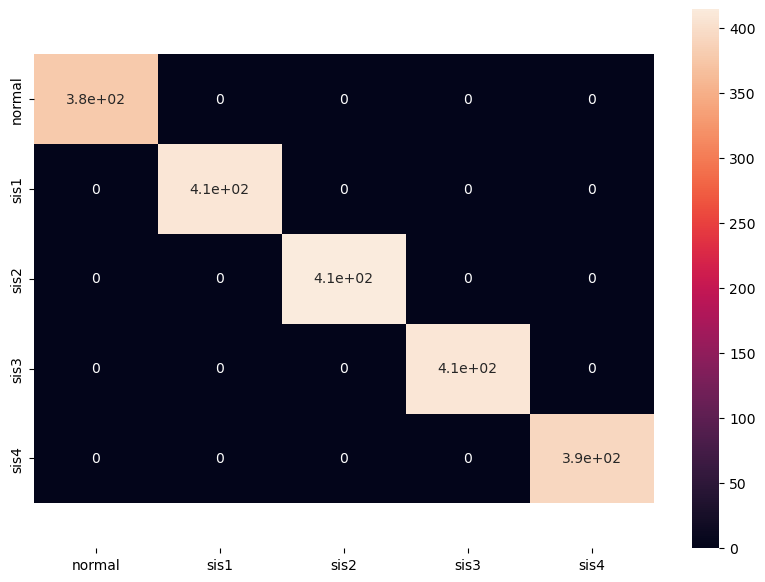

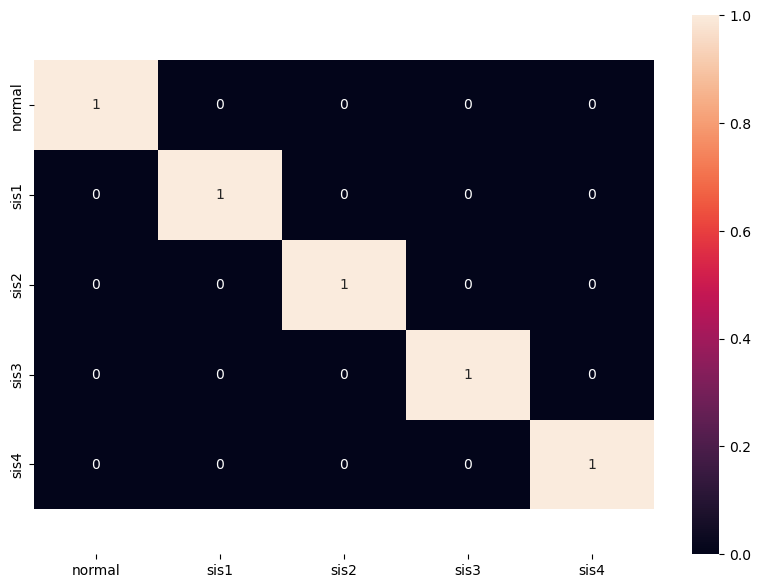

In [ ]:
predict=[]
for i in range(len(pred_labels)):
    predict.append(pred_labels[i][0].detach().cpu())
predict
predd=[]
for i in range(len(predict)):
    predd.append(torch.argmax(predict[i]))
confusionmatrix(predd, true_labels)


In [ ]:
def tsneplotafter(loader1):
    TSNEmodel = TSNE(learning_rate=100)

    xsource=[]
    ysource=[]
    # xtarget=[]
    # ytarget=[]

        
        
    for batch_idx, batch_data2 in enumerate(loader1):
            X_t,X_t2, X_s,X_s2, tlabel = batch_data2
            X_s = Variable(X_s.to(device))
            X_s2 = Variable(X_s2.to(device))
            s_r,s_f,s_feature = best_senc(X_s,X_s2)
            pred, s_log, s_features  = best_scls(s_feature)
        

            xsource.append(np.array(pred.detach().cpu()))
            ysource.append(tlabel.item())
    # for batch_idx, batch_data2 in enumerate(loader2):
    #         tinput, tlabel = batch_data2
    #         tinput = Variable(tinput.to(device))
    #         tinput = feature_extractor(tinput)
    #         xtarget.append(np.array(tinput.detach().cpu()))
    #         ytarget.append(tlabel.item())

    xsource=np.array(xsource)
    ysource=np.array(ysource)
    # xtarget=np.array(xtarget)
    # ytarget=np.array(ytarget)

#     for i in range(len(ytarget)):
#         if ytarget[i]==0:
#             ytarget[i]=5
#         elif ytarget[i]==1:
#             ytarget[i]=6
#         elif ytarget[i]==2:
#             ytarget[i]=7
#         elif ytarget[i]==3:
#             ytarget[i]=8
#         else:
#             ytarget[i]=9 
            
    xsource=xsource.reshape(ysource.size,-1)
    # xtarget=xtarget.reshape(ytarget.size,-1)
    ysource=ysource.reshape(-1,1)
    # ytarget=ytarget.reshape(-1,1)
    
    source=np.hstack([xsource,ysource])
    # target=np.hstack([xtarget,ytarget])
    # tsne=np.vstack([source,target])
    tsne2=source[source[:,-1].argsort()]

    source_normal=np.where(tsne2[:,-1] == 0)[0][0]
    source_sis1=np.where(tsne2[:,-1] == 1)[0][0]
    source_sis2=np.where(tsne2[:,-1] == 2)[0][0]
    source_sis3=np.where(tsne2[:,-1] == 3)[0][0]
    source_sis4=np.where(tsne2[:,-1] == 4)[0][0]
    
    # target_normal=np.where(tsne2[:,-1] == 5)[0][0]
    # target_sis1=np.where(tsne2[:,-1] == 6)[0][0]
    # target_sis2=np.where(tsne2[:,-1] == 7)[0][0]
    # target_sis3=np.where(tsne2[:,-1] == 8)[0][0]
    # target_sis4=np.where(tsne2[:,-1] == 9)[0][0]
    tsne_X = TSNEmodel.fit_transform(tsne2[:,:-1],tsne2[:,-1])

    plt.figure(figsize=(10,10))
    
    plt.scatter(tsne_X[:source_sis1,0],tsne_X[:source_sis1,1],c='red',marker='o', label = 'source normal')
    plt.scatter(tsne_X[source_sis1:source_sis2,0],tsne_X[source_sis1:source_sis2,1],c='blue',marker='o', label = 'source sis1')
    plt.scatter(tsne_X[source_sis2:source_sis3,0],tsne_X[source_sis2:source_sis3,1],c='yellow',marker='o', label = 'source sis2')
    plt.scatter(tsne_X[source_sis3:source_sis4,0],tsne_X[source_sis3:source_sis4,1],c='black',marker='o', label = 'source sis3')
    plt.scatter(tsne_X[source_sis4:,0],tsne_X[source_sis4:,1],c='purple',marker='o' ,label = 'source sis4')
    
#     plt.scatter(tsne_X[target_normal:target_sis1,0],tsne_X[target_normal:target_sis1,1],c='red',marker='s', label = 'target normal')
#     plt.scatter(tsne_X[target_sis1:target_sis2,0],tsne_X[target_sis1:target_sis2,1],c='blue',marker='s', label = 'target sis1')
#     plt.scatter(tsne_X[target_sis2:target_sis3,0],tsne_X[target_sis2:target_sis3,1],c='yellow',marker='s', label = 'target sis2')
#     plt.scatter(tsne_X[target_sis3:target_sis4,0],tsne_X[target_sis3:target_sis4,1],c='black',marker='s', label = 'target sis3')
#     plt.scatter(tsne_X[target_sis4:,0],tsne_X[target_sis4:,1],c='purple',marker='s', label = 'target sis4')

    plt.suptitle('tsne after')
    # plt.legend()

    plt.show()

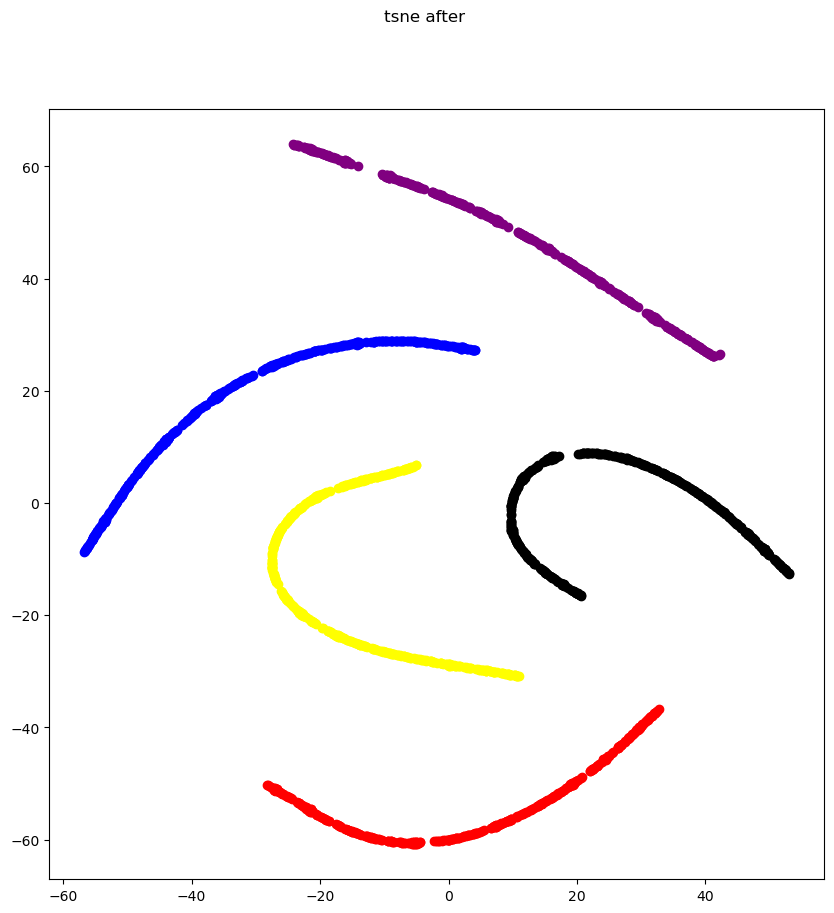

In [ ]:
tsneplotafter(test_distill_dataloader)

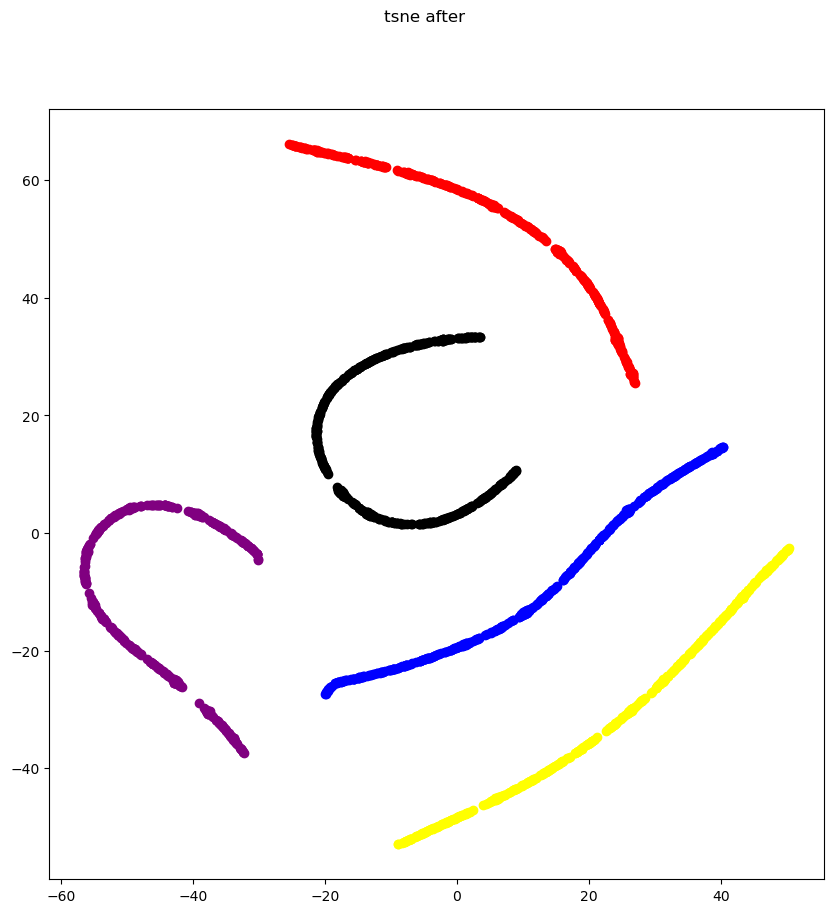

In [ ]:
tsneplotafter(test_distill_dataloader)